In [56]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections

pd.set_option("display.max_column", 999)
print(os.listdir("./"))

['.DS_Store', 'requirements.txt', 'submission.csv', 'README.md', '.gitignore', '2023-winner.ipynb', 'pub-march-machine-learning-mania-2024.ipynb', 'venv', 'march-machine-learning-mania-2024', '.git']


# Load the data!

In [57]:
DATA_PATH = './march-machine-learning-mania-2024/'

tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneyDetailedResults.csv"),
    pd.read_csv(DATA_PATH + "WNCAATourneyDetailedResults.csv"),
], ignore_index=True)

seeds = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv"),
    pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv"),
], ignore_index=True)

regular_results = pd.concat([
    pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv"),
    pd.read_csv(DATA_PATH + "WRegularSeasonDetailedResults.csv"),
], ignore_index=True)


In [58]:
tourney_results.shape

(2142, 34)

In [59]:
seeds.shape

(4234, 3)

In [60]:
regular_results.shape

(189438, 34)

In [61]:
regular_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [62]:
regular_results.select_dtypes(include=[np.number]).groupby('Season').mean()

,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
Season,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003,74.808709,1285.591854,75.795061,1281.750867,63.756932,0.061308,26.299393,55.367851,6.695624,17.377166,16.500650,23.250217,11.580589,25.143847,15.278380,14.211872,7.622184,3.756282,17.880633,22.869584,56.866118,5.824090,18.720971,12.193674,18.055243,11.913345,21.115901,11.877816,15.602903,6.507582,2.768198,20.413128
2004,75.335156,1285.931306,74.971122,1280.900678,62.990155,0.071319,25.928681,55.069350,6.708160,17.570335,16.405601,23.286371,11.608182,25.049880,15.137169,14.049880,7.742070,3.639029,17.798075,22.569241,56.301247,5.826515,18.825202,12.025159,18.057755,11.844235,21.224021,11.870269,15.654999,6.493984,2.741413,20.322468
2005,75.042567,1286.067166,74.693690,1282.088770,62.635294,0.066524,25.975187,54.949305,6.769840,17.678503,15.973476,22.787594,11.565775,24.964920,15.184385,13.907380,7.699251,3.730053,17.403850,22.427594,56.047914,5.904385,18.922139,11.875722,17.767059,11.733690,21.038717,11.771551,15.490481,6.509733,2.806203,19.884492
2006,74.712634,1283.769182,74.587555,1285.425478,62.666597,0.073996,25.920538,54.881228,6.845281,17.821526,15.901198,22.458272,11.591760,24.641581,15.141896,13.893000,7.616985,3.708430,17.253731,22.456801,55.836872,5.945133,18.882279,11.807862,17.589027,11.762035,20.874711,11.833929,15.521127,6.368089,2.836872,19.679210
2007,71.676780,1286.476700,74.829467,1283.896887,62.761650,0.067618,25.896887,54.196907,7.043228,18.138608,15.992465,22.698989,11.222487,24.756098,15.043030,13.909974,7.179853,3.735277,17.443783,22.419790,55.712274,6.059092,19.453500,11.862978,17.645251,11.534404,20.671227,11.667460,15.218917,6.225858,2.760658,19.985524
2008,68.392020,1288.741817,74.962425,1281.907418,62.755375,0.072439,25.932597,54.543289,7.162309,18.386791,15.934922,22.575828,11.133256,25.101491,14.921557,13.720705,7.300213,3.777455,17.450126,22.392408,55.829556,6.165408,19.622119,11.805152,17.567306,11.340306,21.026148,11.578346,15.173155,6.171025,2.836529,19.803021
2009,70.963612,1287.680511,74.033721,1281.312250,61.980377,0.071633,25.724138,54.550200,6.749095,17.743189,15.836350,22.485616,11.178129,25.155839,14.568108,13.223852,7.161174,3.723757,17.297390,22.168223,55.771004,5.759954,18.787579,11.883978,17.740331,11.440846,21.195847,11.328062,14.696895,6.093161,2.777481,19.574776
2010,70.530000,2264.506505,72.629515,2261.125437,59.580971,0.059029,25.443786,56.196893,6.206408,16.806019,15.535534,22.085049,12.321942,26.068932,14.569903,14.909126,8.143204,3.848058,16.811359,21.342718,56.707476,5.180291,17.585049,11.715243,17.524272,12.310680,21.963689,11.016214,16.650097,6.826893,2.861456,19.120388
2011,70.635140,2267.819071,72.557115,2269.176573,59.386641,0.064860,25.368345,56.209197,6.268538,17.049468,15.551888,22.023330,12.257502,26.172217,14.611036,14.643078,8.052953,3.772120,16.798742,21.252081,56.487028,5.240368,17.687318,11.642110,17.396612,12.049177,22.039497,11.027009,16.483543,6.702420,2.914811,19.163311


In [63]:
tourney_results.select_dtypes(include=[np.number]).groupby('Season').mean()

,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
Season,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003,139.156250,1283.343750,76.562500,1288.765625,65.546875,0.093750,27.703125,57.906250,6.640625,16.281250,14.515625,20.218750,11.781250,25.546875,14.765625,12.875000,7.015625,3.890625,17.453125,23.375000,58.906250,6.515625,19.968750,12.281250,17.796875,12.421875,21.171875,12.031250,13.828125,6.062500,3.281250,18.875000
2004,139.156250,1286.515625,75.500000,1300.640625,64.265625,0.046875,25.890625,54.531250,6.906250,17.500000,16.812500,23.296875,11.125000,25.875000,14.859375,12.546875,6.921875,3.625000,16.625000,23.140625,58.468750,6.203125,20.468750,11.781250,16.750000,11.734375,20.593750,12.296875,12.734375,6.015625,2.031250,19.843750
2005,139.156250,1306.031250,75.562500,1299.562500,65.375000,0.109375,26.281250,54.609375,6.953125,18.015625,16.046875,22.203125,10.609375,25.203125,15.093750,13.078125,7.031250,3.484375,17.000000,23.531250,58.546875,6.328125,19.734375,11.984375,17.234375,12.359375,20.984375,12.265625,13.687500,6.781250,2.343750,19.468750
2006,139.156250,1282.250000,73.203125,1291.500000,63.171875,0.109375,24.984375,54.093750,6.609375,18.015625,16.625000,22.640625,11.109375,24.718750,14.125000,11.906250,6.718750,4.250000,15.562500,22.984375,57.234375,6.171875,19.890625,11.031250,15.625000,11.859375,21.375000,12.187500,13.375000,6.171875,3.171875,19.406250
2007,139.156250,1320.593750,75.703125,1299.421875,63.578125,0.093750,25.515625,54.250000,7.421875,18.406250,17.250000,23.531250,11.531250,25.500000,13.921875,12.265625,6.156250,4.015625,16.796875,22.937500,57.390625,6.046875,19.984375,11.656250,16.875000,11.359375,20.406250,11.500000,12.468750,5.906250,2.843750,20.328125
2008,139.156250,1329.781250,77.218750,1292.046875,63.281250,0.093750,27.500000,55.453125,6.937500,17.375000,15.281250,21.265625,11.312500,26.546875,15.218750,12.718750,6.515625,4.062500,17.468750,22.375000,57.390625,6.250000,20.609375,12.281250,18.171875,11.578125,20.031250,10.890625,12.593750,6.171875,2.890625,19.093750
2009,139.156250,1300.187500,77.250000,1284.843750,64.343750,0.046875,27.062500,57.000000,6.453125,17.265625,16.671875,23.000000,11.812500,26.531250,15.546875,12.250000,6.796875,3.687500,16.453125,23.296875,59.328125,5.968750,20.250000,11.781250,16.953125,11.734375,21.109375,11.703125,12.593750,5.953125,3.234375,19.593750
2010,140.165354,2277.984252,73.574803,2297.748031,60.015748,0.086614,26.007874,57.157480,6.236220,17.047244,15.322835,21.370079,12.496063,26.968504,15.283465,13.307087,7.637795,4.346457,15.511811,21.952756,58.913386,5.472441,18.881890,10.637795,15.763780,12.307087,21.779528,11.188976,14.307087,6.771654,3.078740,18.488189
2011,140.038462,2251.992308,73.523077,2266.100000,60.184615,0.053846,26.184615,56.630769,6.284615,16.592308,14.869231,20.238462,12.000000,26.338462,15.061538,12.784615,7.353846,4.023077,15.076923,22.015385,57.715385,5.730769,19.061538,10.423077,14.861538,11.600000,21.438462,11.369231,14.107692,6.315385,2.715385,18.053846


In [64]:
seeds.tail()

,Season,Seed,TeamID
4229,2024,Z12b,3435
4230,2024,Z13,3267
4231,2024,Z14,3238
4232,2024,Z15,3263
4233,2024,Z16,3394


In [65]:
tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19


In [66]:
all(regular_results.columns == tourney_results.columns)

True

# Data preparation!

In [67]:
tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneyDetailedResults.csv"),
    pd.read_csv(DATA_PATH + "WNCAATourneyDetailedResults.csv"),
], ignore_index=True)

seeds = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv"),
    pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv"),
], ignore_index=True)

regular_results = pd.concat([
    pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv"),
    pd.read_csv(DATA_PATH + "WRegularSeasonDetailedResults.csv"),
], ignore_index=True)

"""
This function takes in a dataframe and performs the following operations:
- Concatenates the dataframe with a copy of itself with the winning and losing teams swapped
- Changes the location of the game to a numerical value (0 for neutral, 1 for home, -1 for away)
- Adds a point differential column
- Returns the new dataframe
"""
def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [68]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

In [69]:
regular_data.shape

(378876, 35)

In [70]:
tourney_data.shape

(4284, 35)

In [71]:
regular_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,10,1104,68,1328,62,0,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,6
1,2003,10,1272,70,1393,63,0,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,7
2,2003,11,1266,73,1437,61,0,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,12
3,2003,11,1296,56,1457,50,0,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,6
4,2003,11,1400,77,1208,71,0,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,6


In [72]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,134,1421,92,1411,84,0,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22,8
1,2003,136,1112,80,1436,51,0,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15,29
2,2003,136,1113,84,1272,71,0,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18,13
3,2003,136,1141,79,1166,73,0,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21,6
4,2003,136,1143,76,1301,74,0,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19,2


# Feature engineering!

In [73]:
tourney_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'PointDiff'],
      dtype='object')

In [74]:
boxscore_cols = ['T1_Score', 'T2_Score', 
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 
        'PointDiff']

boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

funcs = [np.mean]

In [75]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.head() # Contains average regular season statistics for each team, separated by season (VERY smart and useful)

/var/folders/bg/q5cqnlzn75sfv4yb_k6p9pcm0000gn/T/ipykernel_6112/1988842530.py:1: FutureWarning: The provided callable <function mean at 0x106f36ac0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()


,Season,T1_TeamID,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_OR,T1_Ast,T1_TO,T1_Stl,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_OR,T2_Ast,T2_TO,T2_Stl,T2_Blk,PointDiff
,,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [76]:
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [77]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [78]:
season_statistics_T1.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [79]:
season_statistics_T2.head()

,Season,T2_TeamID,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [80]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,134,1421,92,1411,84,0,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22,8
1,2003,136,1112,80,1436,51,0,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15,29
2,2003,136,1113,84,1272,71,0,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18,13
3,2003,136,1141,79,1166,73,0,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21,6
4,2003,136,1143,76,1301,74,0,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19,2


In [81]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score
0,2003,134,1421,92,1411,84
1,2003,136,1112,80,1436,51
2,2003,136,1113,84,1272,71
3,2003,136,1141,79,1166,73
4,2003,136,1143,76,1301,74


In [82]:
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [83]:
tourney_data.head()
"""
This dataframe now contains all tournament games and outcomes, but with each team's average regular season stats as well. 
"""

"\nThis dataframe now contains all tournament games and outcomes, but with each team's average regular season stats as well. \n"

In [84]:
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

In [85]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')
tourney_data.head()
"""
Now, we have the win ratio of each team in the last 14 days of the regular season as a feature in the tournament data.
"""

'\nNow, we have the win ratio of each team in the last 14 days of the regular season as a feature in the tournament data.\n'

In [86]:
# Regular season - adding column for whether or not team 1 won
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)


march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)


regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(20266, 5)

In [87]:
regular_season_effects.head()
# Regular season dataframe. Contains point differential and boolean for whether or not team 1 won

,Season,T1_TeamID,T2_TeamID,PointDiff,win
0,2003,1104,1328,6,1
1,2003,1272,1393,7,1
2,2003,1323,1237,44,1
3,2003,1242,1221,24,1
4,2003,1390,1462,1,1


In [88]:
"""
This function is particularly interesting. It uses the parameters of a fitted generalized linear model as a measure of team quality, 
and works as follows:

1. Defines the predictive function (formula). In this case, we are attempting to predict the win column based EXCLUSIVELY on the team IDs
2. Fits a glm based on this formula to regular_season_effects (see previous code cell), specific to the season parameter
3. Extracts the parameters of the glm and stores them in the quality dataframe. These parameters are used as a measure of team quality
"""
def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    #quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality

In [89]:
"""
This is a test of the above function. As a sanity check, I also added the team names to the output dataframe.

I'm not entirely sure if it's working as expected (see below)

It could be working since the team ID numbers are different (and not indicative of team skill at all), and the glm is trying to reconcile for that.

Generally I need to figure out why/how this is even working and useful in the first place.
"""
q = team_quality(2023)

mteams = pd.read_csv(DATA_PATH + "MTeams.csv")
wteams = pd.read_csv(DATA_PATH + "WTeams.csv")

q = pd.merge(q, mteams, on='TeamID', how='left').drop(['FirstD1Season', 'LastD1Season'], axis=1)
q = pd.merge(q, wteams, on='TeamID', how='left', suffixes=('', '_y'))
q['TeamName'] = q['TeamName'].combine_first(q['TeamName_y'])
q = q.drop(['TeamName_y'], axis=1)

print(q['TeamName'].isna().sum())
print(q[q['TeamName'] == 'F Dickinson']) # Kenpom 265
print(q[q['TeamName'] == 'Alabama']) # Kenpom 11
print(q[q['TeamName'] == 'Arizona']) # Kenpom 4

/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


0
    TeamID       quality  Season     TeamName
13    1192 -2.875661e+15    2023  F Dickinson
    TeamID       quality  Season TeamName
0     1104  6.447588e+14    2023  Alabama
67    3104  2.020024e+15    2023  Alabama
    TeamID       quality  Season TeamName
1     1112  8.171813e+14    2023  Arizona
68    3112  4.463955e+15    2023  Arizona


In [90]:
glm_quality = pd.concat([team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                         team_quality(2019),
                         #team_quality(2020),
                         team_quality(2021),
                         team_quality(2022),
                         team_quality(2023)
                         ]).reset_index(drop=True)

/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/stats

In [91]:
glm_quality.head(20)

,TeamID,quality,Season
0,1115,-1.390621e+15,2010
1,1124,3.410081e+15,2010
2,1139,2.919184e+15,2010
3,1140,4.150375e+15,2010
4,1143,2.701393e+15,2010
5,1155,3.455108e+15,2010
6,1165,1.164801e+15,2010
7,1181,4.201799e+15,2010
8,1190,-1.273809e+16,2010
9,1196,1.714340e+15,2010


In [92]:
glm_quality.tail()

,TeamID,quality,Season
1677,3436,1.299682e+15,2023
1678,3437,3.627037e+15,2023
1679,3439,3.436535e+15,2023
1680,3450,4.592193e+15,2023
1681,3452,1.220687e+15,2023


In [93]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

In [94]:
glm_quality_T2.head()

,T2_TeamID,T2_quality,Season
0,1115,-1.390621e+15,2010
1,1124,3.410081e+15,2010
2,1139,2.919184e+15,2010
3,1140,4.150375e+15,2010
4,1143,2.701393e+15,2010


In [95]:
tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [96]:
tourney_data.head()
# Now tourney_data contains quality ratings for each team as well (for 2010 on, should investigate why that is)

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_quality,T2_quality
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,24.733333,55.266667,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667,1.000000,0.833333,NaN,NaN
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,24.827586,55.862069,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172,0.666667,1.000000,NaN,NaN
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,55.655172,5.448276,15.896552,11.000000,14.068966,15.517241,6.000000,3.931034,6.793103,26.275862,60.000000,7.000000,20.068966,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655,0.666667,0.750000,NaN,NaN
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,10.586207,15.620690,18.241379,7.103448,20.965517,26.344828,57.931034,4.965517,13.896552,12.241379,11.793103,16.068966,8.448276,2.482759,6.103448,28.696970,57.454545,7.969697,20.484848,10.878788,16.818182,13.363636,8.393939,17.272727,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091,1.000000,1.000000,NaN,NaN
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,11.241379,16.000000,14.172414,6.551724,17.103448,25.379310,58.793103,7.103448,21.448276,11.172414,16.034483,14.931034,5.931034,2.517241,4.724138,24.333333,53.333333,7.966667,22.500000,9.733333,14.666667,14.200000,7.766667,18.666667,23.433333,53.133333,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000,0.333333,0.600000,NaN,NaN


In [97]:
seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [98]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3])) # Isolating only the numerical value of the seed
seeds.tail()

,Season,Seed,TeamID,seed
4229,2024,Z12b,3435,12
4230,2024,Z13,3267,13
4231,2024,Z14,3238,14
4232,2024,Z15,3263,15
4233,2024,Z16,3394,16


In [99]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

In [100]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [101]:
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

In [102]:
tourney_data.head()
# Added numerical valued tournament seeds

# To clarify: we are training exclusively on TOURNAMENT GAMES (since we are using tournament seeding as a feature)

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,24.733333,55.266667,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667,1.000000,0.833333,NaN,NaN,16,16,0
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,24.827586,55.862069,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172,0.666667,1.000000,NaN,NaN,1,16,-15
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,55.655172,5.448276,15.896552,11.000000,14.068966,15.517241,6.000000,3.931034,6.793103,26.275862,60.000000,7.000000,20.068966,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655,0.666667,0.750000,NaN,NaN,10,7,3
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,10.586207,15.620690,18.241379,7.103448,20.965517,26.344828,57.931034,4.965517,13.896552,12.241379,11.793103,16.068966,8.448276,2.482759,6.103448,28.696970,57.454545,7.969697,20.484848,10.878788,16.818182,13.363636,8.393939,17.272727,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091,1.000000,1.000000,NaN,NaN,11,6,5
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,11.241379,16.000000,14.172414,6.551724,17.103448,25.379310,58.793103,7.103448,21.448276,11.172414,16.034483,14.931034,5.931034,2.517241,4.724138,24.333333,53.333333,7.966667,22.500000,9.733333,14.666667,14.200000,7.766667,18.666667,23.433333,53.133333,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000,0.333333,0.600000,NaN,NaN,8,9,-1


# Time to build some models!

In [103]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']
y.describe()

count    4284.000000
mean        0.000000
std        17.442357
min       -89.000000
25%       -11.000000
50%         0.000000
75%        11.000000
max        89.000000
dtype: float64

In [104]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    list(last14days_stats_T1.columns[2:999]) + \
    list(last14days_stats_T2.columns[2:999]) + \
    ["Seed_diff"] + ["T1_quality","T2_quality"]

len(features)

45

In [105]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

In [106]:
# Defining a custom objective function for model
# Uses a cauchy distribution (instead of normal), supposedly less sensitive to outliers
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1) # Scaling residuals for gradient - more robust to outliers, determines step direction
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2 # Hessian - determines step size
    return grad, hess

In [107]:
param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] = 'mae' # NOTE: might not want to use mae depending on current year's eval metric
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 3 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 1

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 3, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'silent': 1}


In [108]:
xgb_cv = []
repeat_cv = 3 # recommend 10

# Performs 3 rounds of 5-fold cross validation (with custom objective function defined above)
for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj, # this is where he sets his custom objective function (defined previously)
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:13.35322+0.02160	test-mae:13.35764+0.08659


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [11:29:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:9.46941+0.05667	test-mae:9.75279+0.21837
[100]	train-mae:9.08114+0.05826	test-mae:9.57866+0.23462
[150]	train-mae:8.83942+0.06360	test-mae:9.54694+0.23222
[200]	train-mae:8.63332+0.06584	test-mae:9.54747+0.23197
[203]	train-mae:8.62087+0.06587	test-mae:9.54757+0.23072
Fold repeater 1
[0]	train-mae:13.35363+0.04988	test-mae:13.35908+0.17778


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [11:29:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:9.47530+0.03875	test-mae:9.75870+0.20313
[100]	train-mae:9.07896+0.02704	test-mae:9.60789+0.14652
[150]	train-mae:8.82958+0.02418	test-mae:9.58881+0.12701
[171]	train-mae:8.74106+0.01797	test-mae:9.59300+0.12610
Fold repeater 2
[0]	train-mae:13.35350+0.05835	test-mae:13.35926+0.26125


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [11:29:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:9.47805+0.07168	test-mae:9.73368+0.27238
[100]	train-mae:9.08349+0.06352	test-mae:9.57147+0.26013
[150]	train-mae:8.83698+0.06150	test-mae:9.54902+0.23701
[178]	train-mae:8.71442+0.05641	test-mae:9.54979+0.22353


In [109]:
# This part is important - connects the previous training step to the next one 

# Stores the number of iterations it took to achieve the best mae for each of the 5-fold cross validations
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]

# Stores the best mae for each of the 5-fold cross validations
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]

iteration_counts, val_mae

([np.int64(179), np.int64(146), np.int64(153)],
 [np.float64(9.54338519907089),
  np.float64(9.58688556488072),
  np.float64(9.546698463459204)])

In [110]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()

    # Going to perform kfold cross validation again
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    

    # This time, we're actually going to train the model, clipping the iteration count at the optimal number (as defined above)
    for train_index, val_index in kfold.split(X,y):

        # defining the training and validation sets for this fold
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  

        # training the model (optimizing for mae)
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i], # NOTE: this is where we clip the number of iterations optimally
              verbose_eval = 50
        )

        # making predictions
        preds[val_index] = model.predict(dval_i)
        
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [11:40:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/bg/q5cqnlzn75sfv4yb_k6p9pcm0000gn/T/ipykernel_6112/758591664.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.18807278e+01 -1.94314945e+00  1.24043121e+01  4.50294256e+00
 -1.21026158e+00  1.84822559e+01  1.14043255e+01 -5.84821939e-01
  8.92179489e+00 -9.60748768e+00 -1.81321394e+00  8.16852474e+00
 -9.57472324e-01  5.75459480e+00 -1.14582682e+00 -2.40953398e+00
  6.76817942e+00  2.27301273e+01  4.26341200e+00  1.94972916e+01
  5.28093910e+00  2.02504539e+00  4.33482838e+00  1.60399175e+00
 -9.15533066e-01  8.70241451e+00  1.99195404e+01  4.88102627e+00
  2.89507389e+01  9.88226318e+00  2.03619442e+01  6.44618845e+00
  1.2

Fold repeater 1


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [11:40:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/bg/q5cqnlzn75sfv4yb_k6p9pcm0000gn/T/ipykernel_6112/758591664.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.96193237e+01 -7.48415518e+00  1.68095264e+01 -1.72975433e+00
  5.58294010e+00  2.04902210e+01 -2.68327928e+00  1.67695541e+01
  2.20241451e+01  2.45073748e+00  8.53230286e+00 -5.66535711e-01
 -3.35506153e+00  4.18554020e+00 -6.03034115e+00 -2.92884064e+00
  3.36171150e+00  2.04670868e+01  9.22655523e-01  2.15660167e+00
  5.45628786e+00  6.27778435e+00 -6.03547573e-01  4.71264601e+00
 -5.97856092e+00 -7.30723441e-02  2.87348843e+00  3.93372750e+00
  1.52799149e+01  4.04109812e+00  4.38718510e+00 -4.02296925e+00
  6.6

Fold repeater 2


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [11:40:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/bg/q5cqnlzn75sfv4yb_k6p9pcm0000gn/T/ipykernel_6112/758591664.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-8.47266388e+00  9.33771491e-01 -8.63728905e+00 -6.50425720e+00
  1.78198397e-01 -2.71237159e+00  5.22525460e-02 -4.40140867e+00
  5.78069866e-01  4.43890667e+00 -1.94384837e+00  8.69013965e-01
  2.28051567e+01  7.64694500e+00 -1.91771436e+00  2.37153263e+01
  2.32385235e+01  3.12102628e+00  1.27481680e+01  4.32336807e+00
  2.11667976e+01  1.83850555e+01 -7.14755106e+00  2.09777808e+00
  4.08353090e+00  8.26941776e+00 -2.27819800e-01  4.06669569e+00
 -6.60150576e+00 -4.28254747e+00  4.03564501e+00  4.60851848e-01
  6.8

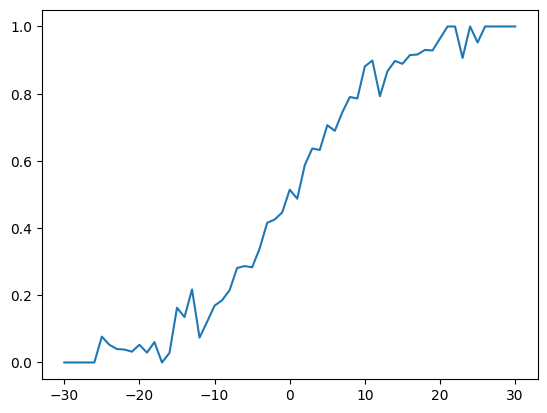

In [111]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [112]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.5157374518066605
logloss of cvsplit 1: 0.5172047708206502
logloss of cvsplit 2: 0.5155360480013157


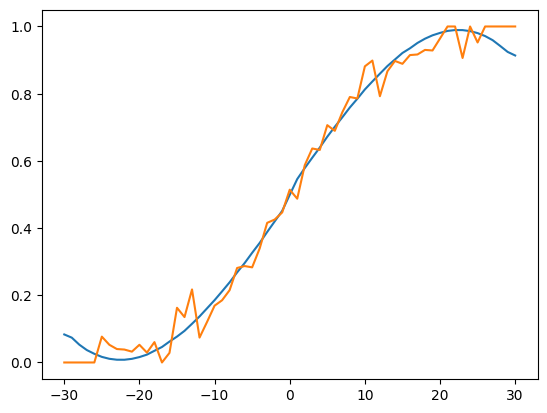

In [113]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')[['spline', 'label']].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int, plot_df.spline)
plt.plot(plot_df.pred_int, plot_df.label)

In [114]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5145544778341347
adjusted logloss of cvsplit 1: 0.5159527812602287
adjusted logloss of cvsplit 2: 0.5143230750295847


In [115]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 1.0780902566927535
adjusted logloss of cvsplit 1: 1.079632080784074
adjusted logloss of cvsplit 2: 1.0780834118313274


In [116]:
#looking for upsets
pd.concat(
    [tourney_data[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score > tourney_data.T2_Score)]]
)

#https://en.wikipedia.org/wiki/NCAA_Division_I_Women%27s_Basketball_Tournament_upsets

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff
3156,2018,137,1438,54,1420,74,25.000000,54.181818,7.363636,18.878788,8.393939,13.727273,8.575758,6.787879,14.060606,18.818182,50.151515,6.151515,20.303030,8.393939,8.848485,12.727273,3.878788,2.636364,14.151515,25.612903,58.451613,9.838710,25.774194,9.709677,14.870968,11.677419,7.387097,16.516129,25.322581,56.612903,8.322581,23.161290,9.935484,13.580645,14.322581,6.258065,2.806452,1.516129,1.000000,1.000000,3.627361e+15,-6.192710e+14,1,16,-15
3413,2023,137,1345,58,1192,63,25.441176,55.382353,6.882353,21.088235,11.029412,15.500000,10.411765,4.794118,13.705882,24.058824,57.705882,6.411765,20.411765,6.323529,12.382353,9.088235,6.000000,2.941176,10.352941,27.781250,61.593750,7.843750,22.781250,9.875000,14.312500,11.156250,7.437500,19.125000,26.656250,55.062500,8.156250,22.093750,7.687500,15.031250,14.187500,5.593750,3.875000,0.312500,1.000000,0.666667,6.944138e+14,-2.875661e+15,1,16,-15
2747,2012,137,1181,70,1250,75,25.757576,56.272727,8.121212,21.606061,11.909091,12.454545,12.181818,6.242424,18.181818,25.515152,58.909091,4.454545,14.060606,11.696970,11.151515,12.909091,5.666667,2.666667,9.060606,25.750000,57.812500,7.406250,20.875000,10.843750,13.000000,11.531250,7.812500,17.781250,23.187500,55.562500,5.968750,17.906250,10.218750,13.062500,14.687500,5.687500,3.843750,10.218750,0.500000,1.000000,1.900484e+15,-8.957460e+15,2,15,-13
2750,2012,137,1281,84,1313,86,28.000000,55.588235,8.235294,20.823529,9.176471,16.205882,10.294118,8.205882,14.117647,24.617647,55.794118,6.235294,17.205882,10.764706,12.823529,14.411765,5.264706,2.647059,14.558824,24.312500,54.281250,5.343750,17.031250,11.187500,12.000000,14.812500,6.531250,19.093750,23.375000,57.687500,5.625000,18.468750,12.281250,11.093750,13.656250,6.593750,3.125000,2.812500,1.000000,1.000000,5.543269e+13,-3.547481e+14,2,15,-13
2810,2013,137,1207,68,1195,78,23.000000,50.419355,5.870968,16.419355,9.225806,14.806452,12.677419,7.548387,16.870968,19.419355,51.612903,5.354839,17.580645,10.806452,10.903226,14.225806,6.354839,3.290323,8.838710,26.218750,57.500000,6.625000,20.031250,11.687500,13.718750,14.656250,8.812500,17.593750,23.625000,57.468750,6.875000,21.843750,12.000000,13.281250,15.656250,6.937500,3.031250,5.031250,0.500000,1.000000,-7.355761e+12,5.633197e+14,2,15,-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1125,2021,137,1317,78,1345,69,25.080000,53.280000,7.400000,19.840000,7.280000,13.040000,12.560000,6.840000,5.520000,21.320000,52.920000,5.720000,18.120000,7.720000,9.160000,13.520000,6.480000,2.960000,7.640000,25.518519,56.555556,7.111111,21.222222,9.666667,14.296296,11.888889,5.185185,4.481481,23.333333,56.333333,8.111111,25.740741,7.407407,14.074074,10.703704,5.592593,3.444444,4.814815,0.666667,0.666667,-1.667577e+15,3.612813e+15,13,4,9
1146,2021,138,1325,62,1438,58,29.545455,60.681818,8.590909,23.500000,8.500000,17.636364,11.545455,6.636364,4.136364,25.954545,58.454545,7.863636,23.363636,8.000000,13.681818,14.136364,5.636364,2.409091,7.045455,25.333333,52.750000,8.500000,22.291667,5.541667,13.958333,8.583333,4.916667,3.375000,22.041667,53.000000,6.708333,19.708333,5.875000,11.625000,8.625000,5.125000,

In [117]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.49150760805781046
adjusted logloss of cvsplit 1: 0.4931122760553165
adjusted logloss of cvsplit 2: 0.49143026784784405


In [118]:
val_cv = []
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    val_cv.append(pd.DataFrame({"y":np.where(y>0,1,0), "pred":spline_fit, "season":tourney_data.Season}))
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
    
val_cv = pd.concat(val_cv)
val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))

adjusted logloss of cvsplit 0: 0.49150760805781046
adjusted logloss of cvsplit 1: 0.4931122760553165
adjusted logloss of cvsplit 2: 0.49143026784784405


/var/folders/bg/q5cqnlzn75sfv4yb_k6p9pcm0000gn/T/ipykernel_6112/1651078057.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))


season
2003    0.514686
2004    0.483880
2005    0.494262
2006    0.546651
2007    0.425062
2008    0.454535
2009    0.459615
2010    0.468060
2011    0.481773
2012    0.484099
2013    0.509348
2014    0.486804
2015    0.423460
2016    0.540185
2017    0.473199
2018    0.530584
2019    0.431051
2021    0.531169
2022    0.540928
2023    0.524998
dtype: float64

# Submission time!

Note: the below code doesn't work because the sample submission changed from 2023-2024. The rest of this code likely won't be relevant for us. 

In [119]:
"""
sub["Season"] = 2018
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)
sub.head()
"""
sub = pd.read_csv(DATA_PATH + "SampleSubmission2023.csv")
sub['Season'] = sub['ID'].apply(lambda x: int(x.split('_')[0]))
sub["T1_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
sub["T2_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[2]))
sub.head()


,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2023_1101_1102,0.5,2023,1101,1102
1,2023_1101_1103,0.5,2023,1101,1103
2,2023_1101_1104,0.5,2023,1101,1104
3,2023_1101_1105,0.5,2023,1101,1105
4,2023_1101_1106,0.5,2023,1101,1106


In [120]:
seeds_T1.tail()

,Season,T1_TeamID,T1_seed
4229,2024,3435,12
4230,2024,3267,13
4231,2024,3238,14
4232,2024,3263,15
4233,2024,3394,16


In [121]:
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub = pd.merge(sub, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')

sub = pd.merge(sub, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
sub = pd.merge(sub, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]

sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_quality,T2_quality,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff
0,2023_1101_1102,0.5,2023,1101,1102,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,23.625000,51.125000,8.156250,22.906250,5.625000,15.312500,10.906250,5.750000,17.000000,23.875000,53.687500,5.187500,17.687500,7.937500,10.093750,10.687500,5.718750,3.093750,-0.125000,NaN,NaN,NaN,NaN,0.0,0.0,NaN
1,2023_1101_1103,0.5,2023,1101,1103,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,25.387097,57.451613,8.806452,25.193548,8.387097,13.000000,10.838710,5.774194,16.193548,24.709677,56.806452,7.064516,20.096774,7.322581,11.483871,11.322581,5.709677,3.032258,5.838710,NaN,NaN,NaN,NaN,0.0,0.5,NaN
2,2023_1101_1104,0.5,2023,1101,1104,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,27.764706,62.205882,10.058824,29.764706,11.264706,15.205882,13.588235,6.058824,18.617647,23.941176,64.382353,5.529412,19.705882,9.500000,10.000000,11.411765,7.294118,3.705882,13.676471,NaN,6.447588e+14,NaN,1.0,0.0,0.8,NaN
3,2023_1101_1105,0.5,2023,1101,1105,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,24.233333,56.500000,6.400000,18.466667,8.766667,12.066667,13.733333,7.500000,19.100000,23.600000,55.300000,7.466667,22.066667,9.966667,12.600000,14.166667,7.500000,3.700000,-3.066667,NaN,NaN,NaN,NaN,0.0,0.5,NaN
4,2023_1101_1106,0.5,2023,1101,1106,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,21.800000,58.566667,5.966667,19.400000,10.300000,9.733333,12.300000,5.666667,17.866667,25.733333,58.800000,6.966667,20.400000,10.633333,11.833333,11.266667,6.733333,4.833333,-10.033333,NaN,NaN,NaN,NaN,0.0,0.0,NaN


In [122]:
Xsub = sub[features].values
dtest = xgb.DMatrix(Xsub)

In [123]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [11:43:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Fold repeater 1


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [11:43:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Fold repeater 2


In [124]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)
"""
sub.loc[(sub.T1_seed==1) & (sub.T2_seed==16), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==2) & (sub.T2_seed==15), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==3) & (sub.T2_seed==14), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==4) & (sub.T2_seed==13), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==16) & (sub.T2_seed==1), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==15) & (sub.T2_seed==2), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==14) & (sub.T2_seed==3), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==13) & (sub.T2_seed==4), 'Pred'] = 0.0
"""
sub[['ID','Pred']].to_csv("submission.csv", index = None)

In [125]:
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_quality,T2_quality,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff
0,2023_1101_1102,0.209273,2023,1101,1102,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,23.625000,51.125000,8.156250,22.906250,5.625000,15.312500,10.906250,5.750000,17.000000,23.875000,53.687500,5.187500,17.687500,7.937500,10.093750,10.687500,5.718750,3.093750,-0.125000,NaN,NaN,NaN,NaN,0.0,0.0,NaN
1,2023_1101_1103,0.182808,2023,1101,1103,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,25.387097,57.451613,8.806452,25.193548,8.387097,13.000000,10.838710,5.774194,16.193548,24.709677,56.806452,7.064516,20.096774,7.322581,11.483871,11.322581,5.709677,3.032258,5.838710,NaN,NaN,NaN,NaN,0.0,0.5,NaN
2,2023_1101_1104,0.039830,2023,1101,1104,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,27.764706,62.205882,10.058824,29.764706,11.264706,15.205882,13.588235,6.058824,18.617647,23.941176,64.382353,5.529412,19.705882,9.500000,10.000000,11.411765,7.294118,3.705882,13.676471,NaN,6.447588e+14,NaN,1.0,0.0,0.8,NaN
3,2023_1101_1105,0.241147,2023,1101,1105,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,24.233333,56.500000,6.400000,18.466667,8.766667,12.066667,13.733333,7.500000,19.100000,23.600000,55.300000,7.466667,22.066667,9.966667,12.600000,14.166667,7.500000,3.700000,-3.066667,NaN,NaN,NaN,NaN,0.0,0.5,NaN
4,2023_1101_1106,0.290687,2023,1101,1106,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,21.800000,58.566667,5.966667,19.400000,10.300000,9.733333,12.300000,5.666667,17.866667,25.733333,58.800000,6.966667,20.400000,10.633333,11.833333,11.266667,6.733333,4.833333,-10.033333,NaN,NaN,NaN,NaN,0.0,0.0,NaN


In [ ]:
"""
tourney_results2018 = pd.read_csv('../input/NCAA_2018_Solution_Womens.csv')
tourney_results2018 = tourney_results2018[tourney_results2018.Pred!=-1].reset_index(drop=True)
tourney_results2018.columns = ['ID', 'label']
tourney_results2018 = pd.merge(tourney_results2018, sub, on = 'ID')
log_loss(tourney_results2018.label, tourney_results2018.Pred)
"""